In [1]:
import pandas as pd
import librosa
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# Import for local library
import os
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import util

import soundfile as sf




C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [114]:
df = pd.read_csv('../../SQLqueries/fine_path_species_label.csv', header = None)
df.columns = ['label_id', 'audio_id', 'fine_start_time', 'fine_end_time', 'species', 'sound_type', 'path']
df = util.remove_label_bug(df, verbose=0)

In [115]:
df_all = pd.read_csv('../../SQLqueries/fine_mosquito_species_inc_none.csv', header = None)
df_all.columns = ['label_id', 'audio_id', 'fine_start_time', 'fine_end_time', 'species', 'sound_type', 'path']
df_all = util.remove_label_bug(df_all, verbose=1)

Old dataframe length: 3341
New dataframe length: 3257


In [116]:
df_noise = pd.read_csv('../../SQLqueries/fine_path_non_mosquito.csv', header = None)
df_noise.columns = ['label_id', 'audio_id', 'fine_start_time', 'fine_end_time', 'species', 'sound_type', 'path']
df_noise = util.remove_label_bug(df_noise, verbose=1)

Old dataframe length: 1063
New dataframe length: 1059


In [117]:
# Append larvae recordings from dataframe to mosquito instead of noise.
#This is a hotfix to merge the two types from the database
# Note that species information has gone missing for this field.

# Include all fine data regardless of species
df = df_all.append(df_noise[df_noise["sound_type"] == " 'larvae'"])

In [118]:
# Select noise data as labelled entries of all except larvae type
df_noise = df_noise[df_noise["sound_type"] != " 'larvae'"]

In [119]:
# # cleaning arguments

# remove_paths = ["cow", "COW", "June", "July"]
# idx_remove = []
# idx_test = []
# idx_train = []

# # Holdout data:

# paths_test = [" '/Kenya/sounds/r2016-08-16_11.00.24.549.wav_u2016-08-16_12.54.03.725151.wav'"
#  " '/Kenya/sounds/r2016-08-16_11.01.24.656.wav_u2016-08-16_12.54.08.162335.wav'",
#  " '/Kenya/sounds/r2016-08-16_11.06.24.678.wav_u2016-08-16_12.54.31.132115.wav'",
#  " '/Thai/sounds/#1072-1097.wav'", " '/Thai/sounds/#1115-1126.wav'",
#  " '/Thai/sounds/#1160-1177.wav'", " '/Thai/sounds/#1296-1312.wav'" ,   
#     " '/Culex/sounds/0031_norm.wav'", " '/Culex/sounds/0022_norm.wav'", 
#               " '/Culex/sounds/0023_norm.wav'",
#      " '/Culex/sounds/UNFINISHED - recordings and labels 24-10-17-R4.wav'",
#  " '/Culex/sounds/UNFINISHED - recordings and labels 25-10-17-R4.wav'",
#  " '/Thai/sounds/larvae_#42-44_rec1.wav'",
#  " '/Thai/sounds/larvae_#42-44_rec2.wav'",
#  " '/Thai/sounds/larvae_#42-44_rec3.wav'",
#  " '/Thai/sounds/larvae_#8-11_rec1.wav'",
#  " '/Thai/sounds/larvae_#8-11_rec2.wav'",
#  " '/Thai/sounds/larvae_#8-11_rec3.wav'"]

# for index, path in enumerate(df["path"]):
#     if 'cow' not in path and 'COW' not in path and 'HLC' not in path and 'hlc' not in path and 'June' not in path  and 'July' not in path:
#         idx_train.append(index) 
# df=df.iloc[idx_train]
    
# for index, path in enumerate(df["path"]):
#     for candidate in paths_test:
#         if candidate in path:
#             idx_test.append(index)

# df_signal_test = df.iloc[idx_test]           
# df_signal_train = pd.concat([df, df_signal_test]).drop_duplicates(keep=False)

In [120]:
# Choose to train on data which contains the strings below in the path filename for true holdout data split

index_list_train = []
index_list_test = []

# index_list_Thai_signal = []
# index_list_Thai_larvae = []
# index_list_Culex_signal = []
for index, path in enumerate(df["path"]):

# Logic used before 18/11 to train all the pickled models saved    

#     if 'Thai' not in path and 'Culex/sounds' not in path:
#         index_list_train.append(index)
#     else:
#         # Removing duplicate entries for "xxxx.wav" and "June/Julyxxx_COW.wav"
#         if 'cow' not in path and 'COW' not in path and 'HLC' not in path and 'hlc' not in path and 'June' not in path:
#             index_list_test.append(index)
            
# # Logic used as of 18/11 to train a classifier on all data
#     if 'cow' not in path and 'COW' not in path and 'HLC' not in path and 'hlc' not in path and 'June' not in path:
#         index_list_train.append(index)

# CNN experiment:
#     if 'Thai' in path:
#         if 'larvae' in path:
#             index_list_Thai_larvae.append(index)
#         elif 'cow' not in path and 'COW' not in path and 'HLC' not in path and 'hlc' not in path and 'June' not in path:
#             index_list_Thai_signal.append(index)
        

        
    if 'Culex/sounds' in path:
        index_list_test.append(index)
    else:
        # Removing duplicate entries for "xxxx.wav" and "June/Julyxxx_COW.wav"
        if 'cow' not in path and 'COW' not in path and 'HLC' not in path and 'hlc' not in path and 'June' not in path  and 'July' not in path:
            index_list_train.append(index)
        
        
#     if 'Culex/sounds/' in path and 'Culex/sounds/00' not in path:
#         index_list_Culex_signal.append(index)

print('Number of clips chosen for training:', len(index_list_train))
print('Number of clips chosen for testing:', len(index_list_test))

df_train = df.iloc[index_list_train]
df_test = df.iloc[index_list_test]

# df_Thai_signal = df.iloc[index_list_Thai_signal]
# df_Thai_larvae = df.iloc[index_list_Thai_larvae]
# df_Culex_signal = df.iloc[index_list_Culex_signal]

Number of clips chosen for training: 1852
Number of clips chosen for testing: 934


In [121]:
# Choose to train on noise which contains the strings below in the path filename for true holdout data split

index_list_train = []
index_list_test = []
# for index, path in enumerate(df_noise["path"]):
#     if 'Thai' not in path and 'Culex/sounds/00' not in path:
#         index_list_train.append(index)
#     else:
#         index_list_test.append(index)
        
# Logic used as of 18/11 to train a classifier on all data
for index, path in enumerate(df_noise["path"]):
    if 'Culex' not in path:
        index_list_train.append(index)
    else:
        index_list_test.append(index)

print('Number of clips chosen for training:', len(index_list_train))
print('Number of clips chosen for testing:', len(index_list_test))

df_train_noise = df_noise.iloc[index_list_train]
df_test_noise = df_noise.iloc[index_list_test]

Number of clips chosen for training: 67
Number of clips chosen for testing: 857


In [122]:
# See list of paths used in train/test/noise dataframes
print('Train:', df_train["path"].unique())
print('Test:', df_test["path"].unique())
print('Train noise:', df_train_noise["path"].unique())
print('Test noise:', df_test_noise["path"].unique())

Train: [" '/Bednet/sounds/PH1 01 JULY (2ND HOUR) - DETECTION TRIAL.wav'"
 " '/Bednet/sounds/PH1 30 JUNE (1ST HOUR) - DETECTION TRIAL.wav'"
 " '/CDC/sounds/CDC_An-merus_labelled_800.wav'"
 " '/CDC/sounds/CDC_Cx-quinquefasciatus_labelled_800.wav'"
 " '/Kenya/sounds/r2016-08-16_11.00.24.549.wav_u2016-08-16_12.54.03.725151.wav'"
 " '/Kenya/sounds/r2016-08-16_11.01.24.656.wav_u2016-08-16_12.54.08.162335.wav'"
 " '/Kenya/sounds/r2016-08-16_11.06.24.678.wav_u2016-08-16_12.54.31.132115.wav'"
 " '/Kenya/sounds/r2016-08-16_11.07.24.567.wav_u2016-08-16_12.54.35.527530.wav'"
 " '/Kenya/sounds/r2016-07-25_12.46.19.487.wav_u2016-07-25_13.15.18.593478.wav'"
 " '/LSTMH/sounds/LSTMH telinga audio - edited and labelled.wav'"
 " '/Thai/sounds/#1072-1097.wav'" " '/Thai/sounds/#1115-1126.wav'"
 " '/Thai/sounds/#1160-1177.wav'" " '/Thai/sounds/#1296-1312.wav'"
 " '/Thai/sounds/#1335-1369.wav'" " '/Thai/sounds/#1370-1393.wav'"
 " '/Thai/sounds/#26-60.wav'" " '/Thai/sounds/#423-487.wav'"
 " '/Thai/sounds/#527

### Change file extension to aac to test new codec

In [148]:
df_test = df_test.replace(to_replace = '.[wW][aA][vV]', value = '.aac', regex=True)
df_test_noise = df_test_noise.replace(to_replace = '.[wW][aA][vV]', value = '.aac', regex=True)

In [149]:
# x_s_tr, x_s_tr_l = util.get_wav_for_df(df_train, 8000)
x_s_te, x_s_te_l = util.get_wav_for_df(df_test, 8000)
# x_n_tr, x_n_tr_l = util.get_wav_for_df(df_train_noise, 8000)
x_n_te, x_n_te_l = util.get_wav_for_df(df_test_noise, 8000)

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [9]:
# x_s_Thai, x_s_Thai_l = util.get_wav_for_df(df_Thai_signal, 8000)
# x_s_Thai_larvae, x_s_Thai_larvae_l = util.get_awav_for_df(df_Thai_larvae, 8000)

In [37]:
x_s_Culex, x_s_Culex_l = util.get_wav_for_df(df_Culex_signal, 8000)

In [ ]:
# CULEX UNFINISHED Actually noise due to the "background" class in labels 0, 28, 43 (checked up to 132/272)

In [161]:
# ipd.Audio(x_s_Culex[400], rate=8000)

In [396]:
# Training on entire database:

x_s_tr, _ = util.get_wav_for_df(df_signal_train, 8000)
x_s_te, _ = util.get_wav_for_df(df_signal_test, 8000)
x_n, _ = util.get_wav_for_df(df_noise, 8000)

## Augmenting dataset with extra data and splitting
It now remains to decide on a way of splitting the data for a comprehensive training and test set. We can use cross-validation on a subset of the training set to further select model hyperparameters. We will explictly split into:
* Train signal, train noise
* Test signal, test noise

In [150]:
# noise_path_names_Culex = [ '/Culex/sounds/0001_norm.wav', '/Culex/sounds/0002_norm.wav', '/Culex/sounds/0003_norm.wav',
#  '/Culex/sounds/0004_norm.wav', '/Culex/sounds/0005_norm.wav', '/Culex/sounds/0006_norm.wav', '/Culex/sounds/0007_norm.wav',
#  '/Culex/sounds/0008_norm.wav', '/Culex/sounds/0009_norm.wav', '/Culex/sounds/0010_norm.wav', '/Culex/sounds/0011_norm.wav',
#  '/Culex/sounds/0012_norm.wav', '/Culex/sounds/0013_norm.wav', '/Culex/sounds/0014_norm.wav', '/Culex/sounds/0015_norm.wav',
#  '/Culex/sounds/0016_norm.wav', '/Culex/sounds/0017_norm.wav', '/Culex/sounds/0018_norm.wav', '/Culex/sounds/0019_norm.wav',
#  '/Culex/sounds/0020_norm.wav', '/Culex/sounds/0025_norm.wav', '/Culex/sounds/0041_norm.wav', '/Culex/sounds/0042_norm.wav',
#  '/Culex/sounds/0043_norm.wav', '/Culex/sounds/0044_norm.wav', '/Culex/sounds/0046_norm.wav', '/Culex/sounds/0047_norm.wav', 
#  '/Culex/sounds/0051_norm.wav', '/Culex/sounds/0053_norm.wav', '/Culex/sounds/0054_norm.wav', '/Culex/sounds/0056_norm.wav']

# x_n_add_Culex, s_n_add_Culex = util.get_wav_for_path(noise_path_names_Culex, sr=8000)
# x_n_add_CDC, s_n_add_CDC = util.get_wav_for_path(['/CDC/sounds/background.wav'], sr=8000)


# # Confirmed noise (Dav):
# dav_noise = ['/Experiments/sounds/noise0.wav', '/Experiments/sounds/noise1.wav', '/Experiments/sounds/noise2.wav', 
#              '/Experiments/sounds/noise3.wav', '/Experiments/sounds/noise4.wav', '/Experiments/sounds/noise5.wav', 
#              '/Experiments/sounds/noise6.wav']

# x_n_add_dav, s_n_add_dav = util.get_wav_for_path(dav_noise, sr=8000)


noise_path_names_bednet = ['../../../Data/Semi Field Data/TanzaniaBednetOctober/01-10-2020/A1/2020-10-01_18.49.02.775__v0.aac',
                          '../../../Data/Semi Field Data/TanzaniaBednetOctober/01-10-2020/A1/2020-10-01_18.49.02.775__v1.aac',
                          '../../../Data/Semi Field Data/TanzaniaBednetOctober/01-10-2020/A1/2020-10-01_18.49.02.775__v6.aac']
x_n_add_bednet, x_n_add_bednet_l = util.get_wav_for_path(noise_path_names_bednet, sr=8000)


# noise_path_music = ['F:/Music/Guitar Playthroughs/Audacity/MessengerTesseractBacking.wav',
#                           'F:/Music/Guitar Playthroughs/Audacity/OwaneRektDoubleTrackGuitars.wav',
#                           'F:/Music/Guitar Playthroughs/Audacity/MessengerTesseractBacking.wav']

# x_n_music, _ = get_wav_for_path(noise_path_music, sr=8000)





In [19]:
# # Important: need to filter out duplicates. MUST UPDATE df_all
# x_n_Thai, s_n_Thai = util.get_noise_wav_for_df(df_Thai_signal, ['Thai'], 0.75, 8000, verbose=0)

# x_n_Thai_larvae, s_n_Thai_larvae = util.get_noise_wav_for_df(df_Thai_larvae, ['Thai'], 0.75, 8000, verbose=0)



# Important 2: this function squashes together every noise section into a single array: probably not desired. THink about 
# whether storing each signal with a separate noise fine_start_time and fine_end_time is better instead.

x_n_Thai, s_n_Thai = util.get_noise_wav_for_df(df_train, ['Thai'], 0.75, 8000, verbose=0)
x_n_Culex, s_n_Culex = util.get_noise_wav_for_df(df_test, ['Culex/sounds/00'], 0.00, 8000, verbose=0)


['Thai']
['Culex/sounds/00']


In [15]:
# Print unique species in set(s)
print('Training species')
print(df_train["species"].unique())
print('Testing species')
print(df_test["species"].unique())

Training species
[" 'ae albopictus'" " 'an albimanus'" " 'an arabiensis'"
 " 'an atroparvus'" " 'an coluzzii'" " 'an dirus'" " 'an farauti'"
 " 'an freeborni'" " 'an funestus'" " 'an merus'" " 'an minimus'"
 " 'an quadriannulatus'" " 'an sinensis'" " 'an stephensi'"
 " 'culex quinquefasciatus'" " 'culex tarsalis'"
 " 'toxorhynchites brevipalpis'" " 'an gambiae'" " 'ae aegypti'"]
Testing species
[" 'culex quinquefasciatus'" " 'an dirus'" " 'an harrisoni'"
 " 'an minimus'" " 'an maculatus'" " 'an barbirostris'" ' None']


## Split signal
We hold out some data to split. No obvious split currently so will wing it.

In [16]:
# Run a few files to verify
ipd.Audio(x_n_Thai[48], rate = 8000)


### Features for signal from query

In [14]:
feat_type = 'log-mel'
n_feat = 128
flatten = False
# For current configs, hop length is 512 samples: that means a window size of 10 hops is equivalent to 5120/8000 = 0.64 (s)
win_size = 40
step_size = 5


In [224]:
# X_s_Thai = util.get_feat(x_s_Thai, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_s_Thai_CNN = util.reshape_feat(X_s_Thai, win_size, step_size)

# X_s_Thai_larvae = util.get_feat(x_s_Thai_larvae, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_s_Thai_larvae_CNN = util.reshape_feat(X_s_Thai_larvae, win_size, step_size)

NameError: name 'x_s_Thai' is not defined

In [38]:
X_s_Culex  = util.get_feat(x_s_Culex, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_s_Culex_CNN  = util.reshape_feat(X_s_Culex, win_size, step_size)

In [151]:
# X_s_tr = util.get_feat(x_s_tr, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_s_tr_CNN = util.reshape_feat(X_s_tr, win_size, step_size)

X_s_te = util.get_feat(x_s_te, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
X_s_te_CNN = util.reshape_feat(X_s_te, win_size, step_size)

# X_n_tr = util.get_feat(x_n_tr, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_n_tr_CNN = util.reshape_feat(X_n_tr,  win_size, step_size)

X_n_te = util.get_feat(x_n_te, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
X_n_te_CNN = util.reshape_feat(X_n_te,  win_size, step_size)


In [259]:
# # Full database:

# X_s = util.get_feat(x_s[0], sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# # X_s_CNN = util.reshape_feat(X_s, win_size, step_size) 

# X_n = util.get_feat(x_n[0], sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# # X_n_CNN = util.reshape_feat(X_n, win_size, step_size)

### Features for noise from Culex Q home data and Thai

In [30]:
X_n_Thai = util.get_feat(x_n_Thai, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_n_Thai_CNN = util.reshape_feat(X_n_Thai, win_size, step_size)

# X_n_Thai_larvae = util.get_feat(x_n_Thai_larvae, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=False)
# X_n_Thai_larvae_CNN = util.reshape_feat(X_n_Thai_larvae, win_size, step_size)

X_n_Culex = util.get_feat(x_n_Culex, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_n_Culex_CNN = util.reshape_feat(X_n_Culex, win_size, step_size)


### Features for noise from CDC and remaining Culex data, and other noise


In [25]:
X_n_add_Culex = util.get_feat(x_n_add_Culex, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_n_add_Culex_CNN = util.reshape_feat(X_n_add_Culex, win_size, step_size)


In [152]:
# X_n_add_CDC = util.get_feat(x_n_add_CDC, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_n_add_CDC_CNN = util.reshape_feat(X_n_add_CDC, win_size, step_size)

# X_n_add_dav = util.get_feat(x_n_add_dav, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_n_add_dav_CNN = util.reshape_feat(X_n_add_dav, win_size, step_size)

X_n_add_bednet = util.get_feat(x_n_add_bednet, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
X_n_add_bednet_CNN = util.reshape_feat(X_n_add_bednet, win_size, step_size)

# X_n_music = util.get_feat(x_n_music, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten=flatten)
# X_n_music_CNN = util.reshape_feat(X_n_music, win_size, step_size)

### Concatenate and trim+shuffle for balanced signal and noise

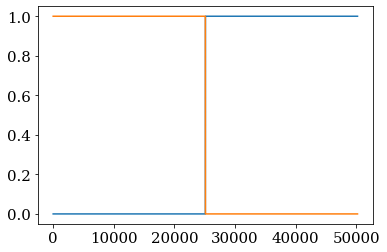

In [128]:
X_test = np.vstack([X_s_te_CNN, X_n_add_bednet_CNN[:len(X_s_te_CNN)]])
y_test = np.zeros([len(X_test),2])
y_test[:len(X_s_te_CNN),1] = 1
y_test[len(X_s_te_CNN):,0] = 1

plt.plot(y_test)

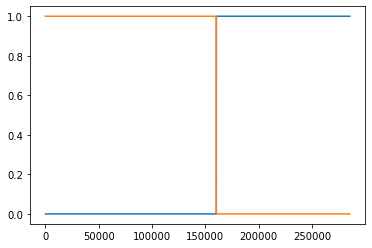

In [31]:
X_train = np.vstack([X_s_tr_CNN, X_n_tr_CNN, X_n_add_CDC_CNN, X_n_Thai_CNN, X_n_add_dav_CNN])
y_train = np.zeros([len(X_train), 2])
end_sample = len(X_s_tr_CNN)
y_train[:end_sample,1] = 1
y_train[end_sample:,0] = 1

plt.plot(y_train)

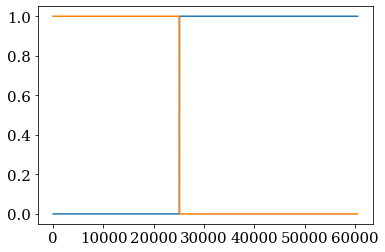

In [153]:
X_test = np.vstack([X_s_te_CNN,  X_n_te_CNN, X_n_add_bednet_CNN])

y_test = np.zeros([len(X_test), 2])
end_sample = len(X_s_te_CNN)
y_test[:end_sample,1] = 1
y_test[end_sample:,0] = 1

plt.plot(y_test)

In [154]:
# Save arrays
with open('X_test_Culex_bednet_aac16k', 'wb') as f:
    np.save(f, X_test)
with open('y_test_Culex_bednet_aac16k', 'wb') as f:
    np.save(f, y_test)

In [425]:
# Data concatenation for CNN:
spec_matrix_db = np.vstack([X_s_tr_CNN, X_n_CNN, X_n_add_CDC_CNN, X_n_add_Culex_CNN, X_n_add_dav_CNN, X_n_Thai_CNN])
end_sample = len(X_s_tr_CNN)

# end_sample = len(X_s_Thai_CNN)
# spec_matrix_db = np.vstack([X_s_Thai_CNN, (X_n_Thai_CNN)[:end_sample]])

y = np.zeros([len(spec_matrix_db), 2])
y[:end_sample,1] = 1
y[end_sample:,0] = 1


# spec_matrix_db_train = np.vstack([X_s_Thai_CNN, shuffle(X_n_Thai_CNN)[:end_sample]])
# spec_matrix_db_test = np.vstack([X_s_Thai_larvae_CNN, shuffle(X_n_Thai_larvae_CNN)[:len(X_s_Thai_larvae_CNN)]])

X_train = spec_matrix_db
y_train = y
# X_test = spec_matrix_db_test

# y_train = np.zeros([len(spec_matrix_db_train), 2])
# y_train[:end_sample,1] = 1
# y_train[end_sample:,0] = 1

# y_test = np.zeros([len(spec_matrix_db_test), 2])
# y_test[:len(X_s_Thai_larvae_CNN),1] = 1
# y_test[len(X_s_Thai_larvae_CNN):,0] = 1

In [293]:
# Data concatenation for RF
X_train = np.vstack([shuffle(X_s)[:170000], X_n_Thai, X_n, X_n_add_dav, X_n_Culex, X_n_add_CDC])
end_sample = len(X_s)

y_train = np.zeros([len(X_train), 1])
y_train[:170000] = 1

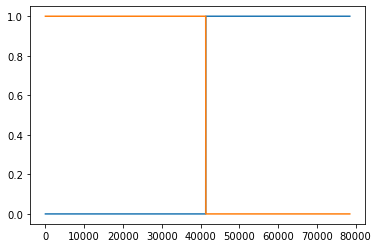

In [426]:
plt.plot(y_train)

In [513]:
from sklearn.model_selection import train_test_split


# Deep learning
# Keras-related imports
from keras.models import Sequential
from keras.layers import Lambda, Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution1D, MaxPooling2D, Convolution2D
from keras import backend as K
# K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint
from keras.callbacks import RemoteMonitor
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2


# Data concatenation for CNN:
# spec_matrix_db = np.vstack([X_s_tr_CNN, X_s_te_CNN, X_n_Thai_CNN, X_n_tr_CNN, X_n_add_dav_CNN, X_n_Culex_CNN, X_n_add_CDC_CNN])
# end_sample = len(X_s_tr_CNN) + len(X_s_te_CNN)
# y = np.zeros([len(spec_matrix_db), 2])
# y[:end_sample,1] = 1
# y[end_sample:,0] = 1
# X_train, X_test, y_train, y_test = train_test_split(spec_matrix_db, np.array(y), test_size=0.01,
#                                                     random_state=42, shuffle=False)
# Normalise by statistics of training data
# X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
# X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)
# X_train_tf = X_train_norm
# X_test_tf = X_test_norm

################################ CONVOLUTIONAL NEURAL NETWORK ################################
## NN parameters
class_weight = {0: 1.,
                1: 1.,
                }
input_shape = (1, X_train.shape[2], X_train.shape[-1])

# BNN parameters
dropout=0.2  # change to 0.05
# Regularise
tau = 1.0
lengthscale = .01
reg = lengthscale**2 * (1 - dropout) / (2. * len(X_train) * tau)

W_regularizer=l2(reg)  # regularisation used in layers

model = Sequential()
n_dense = 128
nb_classes = 2
# number of convolutional filters
nb_conv_filters = 32
# num_hidden = 236
nb_conv_filters_2 = 64
convout1 = Activation('relu')
convout2 = Activation('relu')

model.add(Conv2D(nb_conv_filters, kernel_size = (3,3),
     activation = 'relu', padding = 'valid', strides = 1,
     input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Lambda(lambda x: K.dropout(x,level=dropout)))


model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
     activation = 'relu', padding = 'valid'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Lambda(lambda x: K.dropout(x,level=dropout)))

model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
     activation = 'relu', padding = 'valid'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.2))
model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
     activation = 'relu', padding = 'valid'))
model.add(Lambda(lambda x: K.dropout(x,level=dropout)))

model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
     activation = 'relu', padding = 'valid'))
model.add(Lambda(lambda x: K.dropout(x,level=dropout)))

model.add(Flatten())
# Shared between MLP and CNN:
model.add(Dense(n_dense, activation='relu'))
model.add(Lambda(lambda x: K.dropout(x,level=dropout)))


model.add(Dense(nb_classes, activation='softmax',W_regularizer=l2(reg)))
model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, verbose=1, callbacks=None, validation_split=0.0,
          validation_data=None,
          shuffle=True, class_weight=class_weight, sample_weight=None, initial_epoch=0,
          steps_per_epoch=None, validation_steps=None)


C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:90: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", kernel_regularizer=<keras.reg...)`


Epoch 1/10
46584/46584 [==============================] - 40s 861us/step - loss: 0.2226 - accuracy: 0.9215
Epoch 2/10
46584/46584 [==============================] - 40s 861us/step - loss: 0.0588 - accuracy: 0.9809
Epoch 3/10
46584/46584 [==============================] - 40s 859us/step - loss: 0.0401 - accuracy: 0.9876
Epoch 4/10
46584/46584 [==============================] - 40s 858us/step - loss: 0.0306 - accuracy: 0.9897
Epoch 5/10
46584/46584 [==============================] - 40s 859us/step - loss: 0.0244 - accuracy: 0.9919
Epoch 6/10
30432/46584 [==================>...........] - ETA: 13s - loss: 0.0164 - accuracy: 0.9948

KeyboardInterrupt: 

In [33]:
from scipy.signal import medfilt

In [504]:
preds = model.predict(X_test)


In [514]:
n_samples = 10
out = []
for i in range(n_samples):
    out.append(model.predict(X_test))

In [515]:
G_X, U_X, log_prob = active_BALD(np.log(out), X_test, 2)

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


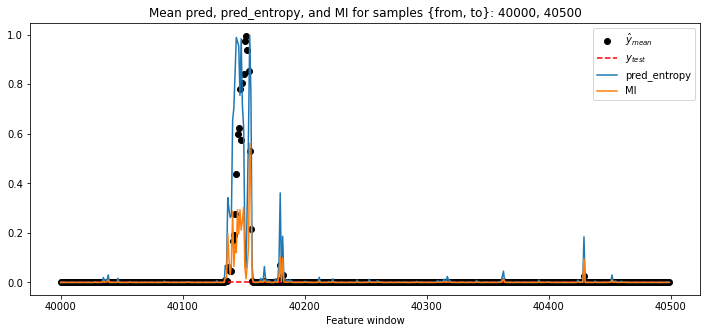

In [516]:
start_vis = 40000
end_vis = 40500
plt.figure(figsize=(12,5))
plt.title('Mean pred, pred_entropy, and MI for samples {from, to}: ' + str(start_vis) + ', ' + str(end_vis))
plt.plot(np.arange(start_vis, end_vis), np.mean(out,axis=0)[start_vis:end_vis,1], 'ko', label='$\hat{y}_{mean}$')
plt.plot(np.arange(start_vis, end_vis), y_test[start_vis:end_vis,1], 'r--', label='${y}_{test}$')
plt.plot(np.arange(start_vis, end_vis),G_X[start_vis:end_vis], label='pred_entropy')
plt.plot(np.arange(start_vis, end_vis),U_X[start_vis:end_vis], label='MI')
plt.xlabel('Feature window')
plt.legend()

In [352]:
np.shape(X_test)

(60521, 1, 40, 128)

In [353]:
np.shape(y_test)

(60521, 2)

In [354]:
def active_BALD(out, X, n_classes):

    log_prob = np.zeros((out.shape[0], X.shape[0], n_classes))
    score_All = np.zeros((X.shape[0], n_classes))
    All_Entropy = np.zeros((X.shape[0],))
    for d in range(out.shape[0]):
#         print ('Dropout Iteration', d)
#         params = unflatten(np.squeeze(out[d]),layer_sizes,nn_weight_index)
        log_prob[d] = out[d]
        soft_score = np.exp(log_prob[d])
        score_All = score_All + soft_score
        #computing F_X
        soft_score_log = np.log2(soft_score+10e-15)
        Entropy_Compute = - np.multiply(soft_score, soft_score_log)
        Entropy_Per_samp = np.sum(Entropy_Compute, axis=1)
        All_Entropy = All_Entropy + Entropy_Per_samp
 
    Avg_Pi = np.divide(score_All, out.shape[0])
    Log_Avg_Pi = np.log2(Avg_Pi+10e-15)
    Entropy_Avg_Pi = - np.multiply(Avg_Pi, Log_Avg_Pi)
    Entropy_Average_Pi = np.sum(Entropy_Avg_Pi, axis=1)
    G_X = Entropy_Average_Pi
    Average_Entropy = np.divide(All_Entropy, out.shape[0])
    F_X = Average_Entropy
    U_X = G_X - F_X
# G_X = predictive entropy
# U_X = MI
    return G_X, U_X, log_prob

In [65]:
preds = model.predict(X_test)
preds_filt = np.zeros([len(preds),2])
preds_filt[:,1] = medfilt(preds[:,1], kernel_size=5)
preds_filt[:,0] = 1 - preds_filt[:,1]

In [546]:
score, acc = model.evaluate(X_test[:], y_test[:])
print(score, acc)

60521/60521 [==============================] - ETA: 0s - loss: 0.2697 - acc: 0.942 - 10s 171us/sample - loss: 0.2694 - acc: 0.9427
0.26944391230280207 0.9427306


In [66]:
accuracy_score(np.round(preds_filt), y_test)

0.921532672695419

In [64]:
accuracy_score(np.round(preds), y_test)

0.9082336336810901

ValueError: x and y must have same first dimension, but have shapes (60000,) and (1769,)

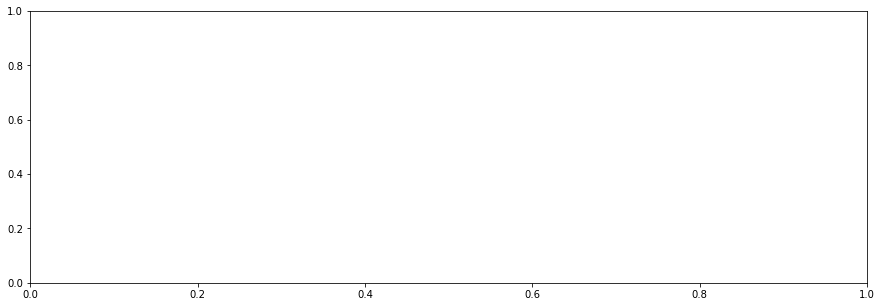

In [520]:
start_vis = 0
end_vis= 60000
plt.figure(figsize=(15,5))
plt.plot(np.arange(start_vis, end_vis), preds[start_vis:end_vis,1], label='raw')
# plt.plot(np.arange(start_vis, end_vis), preds_filt[start_vis:end_vis,1], label= 'medfilt')
plt.plot(np.arange(start_vis, end_vis), y_test[start_vis:end_vis,1], label = 'truth')
plt.legend()

In [49]:
# model = clf

n_samples = 10
data_class = 1 

def mean_pred(test_data, n_samples, data_class):
    for data in test_data:
        preds = []
        accs = []
        for i in range(n_samples):
            preds=model.predict(data)
            y = np.zeros([len(data),2])
            y[:,data_class] = 1
            accs.append(accuracy_score(np.round(preds), y))

        print('mean acc:', np.mean(accs, axis=0), 'pred wins:', len(preds))
        print('std acc:', np.std(accs, axis=0), 'n_samples:', n_samples)
    return 


mean_pred([X_s_te], n_samples, 1)
print('Next exp')
mean_pred([X_n_add_bednet,
           np.vstack([X_n_te,X_n_add_Culex, X_n_Culex])], n_samples, 0)
print('Next exp')
mean_pred([X_n_music],n_samples,0)

# preds = []
# accs = []
# for i in range(n_samples):
#     for data in :
#         preds = model.predict(data)
#         y = np.zeros([len(data),2])
#         y[:,0] = 1
    
#     print('Noise accuracy:', accuracy_score(np.round(np.mean(preds, axis=0)), y),  'Number of prediction windows', len(preds) )


mean acc: 0.8338374255602938 pred wins: 159693
std acc: 0.0 n_samples: 1
Next exp
mean acc: 0.9999407375800784 pred wins: 168741
std acc: 0.0 n_samples: 1
mean acc: 0.9022121772481337 pred wins: 73005
std acc: 0.0 n_samples: 1
Next exp
mean acc: 0.6531033770525664 pred wins: 9683
std acc: 0.0 n_samples: 1


In [156]:
baseline_results = model.evaluate(X_test, y_test)

60528/60528 [==============================] - 8s 132us/sample - loss: 0.4077 - acc: 0.9470


In [157]:
pred_list = []
for i in range(10):
#     pred_list.append(model.predict(np.vstack([X_s_te, X_n_te, X_n_add_bednet, X_n_add_Culex, X_n_Culex])))
    pred_list.append(model.predict(np.vstack([X_s_te_CNN, X_n_te_CNN, X_n_add_bednet_CNN])))

In [158]:
y_cm = np.zeros((len(pred_list[0]),2))

In [159]:
y_cm[:len(X_s_te_CNN),1] = 1
y_cm[len(X_s_te_CNN):,0] = 1

In [160]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [64]:
import sklearn


In [70]:
np.shape(np.argmax(y_test, axis=-1))

(60528,)

In [ ]:
np.shape()

In [144]:
np.shape(X_test)

(60521, 1, 40, 128)

0.9667067887582796

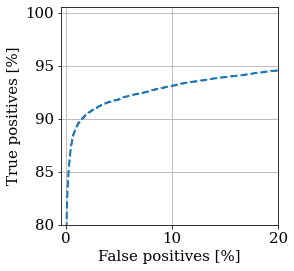

In [161]:
plot_roc("Test performance", np.argmax(y_test, axis=-1), model.predict(X_test)[:,1], linestyle='--')
sklearn.metrics.roc_auc_score(np.argmax(y_test, axis=-1), model.predict(X_test)[:,1])

In [162]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, std,
                          normalize=False,
                                                    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


#     std = std * 100
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] *100
#         std = std.astype('float') / std.sum(axis=1)[:, np.newaxis] *100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, as input by user')

    print(cm)

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,

           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else '.2f'
    fmt_std = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt) + '±' + format(std[i, j], fmt_std),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


cm_list = []
for i in np.arange(len(pred_list)):
        cm_list.append(confusion_matrix(np.argmax(y_cm,-1), np.argmax(pred_list[i],-1)))
        
cm = []
for item in cm_list:
    cm.append(item.astype('float') / item.sum(axis=1)[:, np.newaxis] *100)
cm_mean = np.mean(cm, axis = 0) # Convert mean to normalised percentage
cm_std = np.std(cm, axis = 0) # Standard deviation also in percentage

Confusion matrix, as input by user
[[99.4451  0.5549]
 [11.9837 88.0163]]


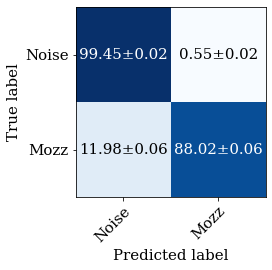

In [163]:
import matplotlib

np.set_printoptions(precision=4)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)


class_names= np.array(['Noise', 'Mozz'])

# Plot normalized confusion matrix
plot_confusion_matrix(cm_mean, std=cm_std, classes=class_names, normalize=False)
# plt.tight_layout()
# plt.savefig('Graphs/cm_RF_BNN.pdf', bbox_inches='tight')
plt.show()

In [465]:
norm=False
model_name = 'held_out_test_manual_v3_low_epoch_batch32'
model.save('../models/BNN/Win_' + str(win_size) + '_Stride_' + str(step_size) + '_CNN_' + 
           str(feat_type) + '_' + str(n_feat) + '_norm_' + str(norm) + model_name + '.h5')

In [27]:
# Save normalisation data:
# X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)

with open('mean_norm.npy', 'wb') as f:
    np.save(f, np.mean(X_train))
with open('std_norm.npy', 'wb') as f:
    np.save(f, np.std(X_train))


# DEBUG SECTION FOR OUT OF SAMPLE PREDICTION PIPELINE

In [ ]:
for i, item in enumerate(range(len(df))):
    print(df.iloc[i]["path"])
    signal, _ = librosa.load('../../Data' + df.iloc[i]["path"].strip().strip("\'"),
                offset=df.iloc[i]["fine_start_time"],
                duration=df.iloc[i]["fine_end_time"] - df.iloc[i]["fine_start_time"], sr = sr)
    x.append(signal)


In [381]:
"{:.2f}".format(preds_list[0][2])

'0.84'

In [386]:
preds_list[0][2] = "{:.2f}".format

0.8367872

In [359]:
np.savetxt('debug_label.txt', preds_list, fmt='%f', delimiter='\t')

In [396]:
def detect_timestamps_BNN(preds_prob, G_X, U_X, hop_length=512, sr=8000):

    preds = np.zeros(len(preds_prob))
    for i, pred in enumerate(preds_prob):
        if pred[1] > 0.5:
            preds[i] = 1


    frames = librosa.frames_to_samples(np.arange(len(preds)), hop_length=512)  
    sample_start = 0
    prob_start_idx = 0
    preds_list = []
    # mozz_pred_array = []
    for index, frame in enumerate(frames[:-1]):
        if preds[index] != preds[index+1]:
            sample_end = frames[index+1]
            prob_end_idx = index+1
            # print('sample_start', sample_start, prob_start_idx, 
            #  'sample_end', sample_end, prob_end_idx, 'label', preds[index])
            if preds[index] == 1:
                preds_list.append([str(sample_start/sr), str(sample_end/sr),
                                   "{:.2f}".format(np.mean(preds_prob[prob_start_idx:prob_end_idx][:,1])) +
                                  " PE: " + "{:.2f}".format(np.mean(G_X[prob_start_idx:prob_end_idx])) + 
                                  " MI: " + "{:.2f}".format(np.mean(U_X[prob_start_idx:prob_end_idx]))])
            sample_start = frames[index+1]  
            prob_start_idx = index+1     

        elif index+1 == len(frames[:-1]):
            sample_end = frames[index+1]
            prob_end_idx = index+1 
            # print('sample_start', sample_start, 'sample_end', sample_end, 'label', preds[index])
            if preds[index] == 1:
                preds_list.append([str(sample_start/sr), str(sample_end/sr),
                                   "{:.2f}".format(np.mean(preds_prob[prob_start_idx:prob_end_idx][:,1])) +
                                  " PE: " + "{:.2f}".format(np.mean(G_X[prob_start_idx:prob_end_idx])) + 
                                  " MI: " + "{:.2f}".format(np.mean(U_X[prob_start_idx:prob_end_idx]))])       
            sample_start = frames[index+1]       
            prob_start_idx = index+1 
    return preds_list

In [20]:
from tensorflow import keras

model = keras.models.load_model('../models/BNN/Win_40_Stride_5_CNN_log-mel_128_norm_Falseheld_out_test_manual_v2_low_epoch.h5',
                               custom_objects={"dropout": 0.2})
model_name = 'held_out_test_manual_v2_low_epoch'
win_size=40
# step_size=40

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ikiskin

In [32]:
culCNN = model.predict(X_s_Culex_CNN)

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_9/Conv2D}}]]
	 [[dense_10/Softmax/_205]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_9/Conv2D}}]]
0 successful operations.
0 derived errors ignored.

In [39]:
with open('proc_data/X_Culex_no_00_log-mel-step5.npy', 'wb') as f:
    np.save(f, X_s_Culex_CNN)

2020-11-10_00.28.03.951.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0000/2020-11-10_00.28.03.951.wav
[['693.76', '696.32', '0.89 PE: 0.50 MI: 0.07'], ['1728.0', '1733.12', '0.94 PE: 0.31 MI: 0.02']]


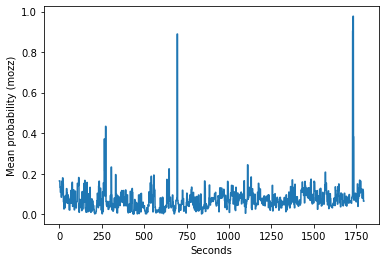

2020-11-10_00.58.03.940.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0000/2020-11-10_00.58.03.940.wav
[['476.16', '478.72', '0.87 PE: 0.55 MI: 0.07']]


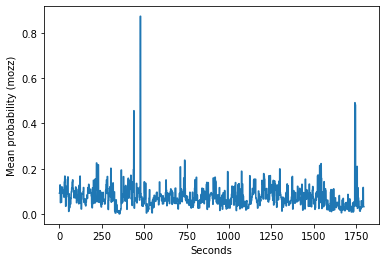

2020-11-10_01.28.03.961.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0100/2020-11-10_01.28.03.961.wav
[['611.84', '614.4', '0.95 PE: 0.29 MI: 0.04'], ['640.0', '642.56', '0.78 PE: 0.76 MI: 0.21'], ['885.76', '890.88', '0.91 PE: 0.33 MI: 0.05']]


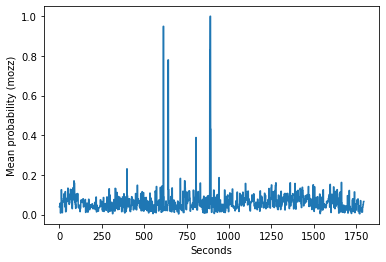

2020-11-10_01.58.03.971.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0100/2020-11-10_01.58.03.971.wav
[]


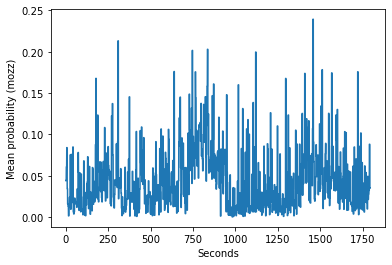

2020-11-10_02.28.03.937.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0200/2020-11-10_02.28.03.937.wav
[]


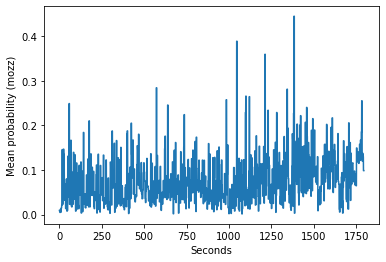

2020-11-10_02.58.03.954.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0200/2020-11-10_02.58.03.954.wav
[]


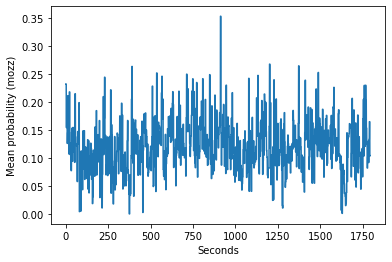

2020-11-10_03.28.03.967.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0300/2020-11-10_03.28.03.967.wav
[['1653.76', '1658.88', '0.61 PE: 0.96 MI: 0.08']]


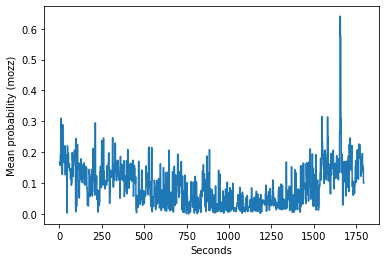

2020-11-10_03.58.03.964.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0300/2020-11-10_03.58.03.964.wav
[['1515.52', '1518.08', '0.71 PE: 0.87 MI: 0.10']]


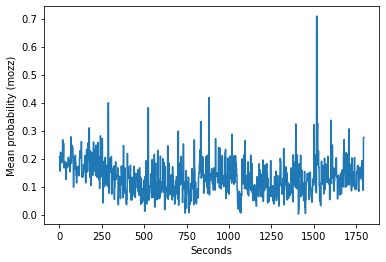

2020-11-10_04.28.03.967.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0400/2020-11-10_04.28.03.967.wav
[]


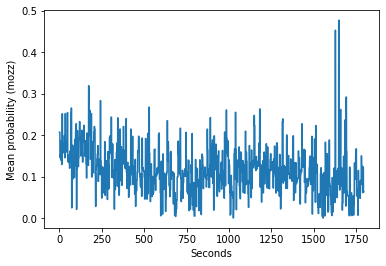

2020-11-10_04.58.03.963.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0400/2020-11-10_04.58.03.963.wav
[['161.28', '163.84', '0.85 PE: 0.61 MI: 0.15'], ['166.4', '168.96', '0.52 PE: 1.00 MI: 0.18'], ['171.52', '174.08', '0.90 PE: 0.47 MI: 0.04'], ['294.4', '299.52', '0.63 PE: 0.92 MI: 0.07'], ['337.92', '340.48', '0.64 PE: 0.94 MI: 0.13'], ['417.28', '419.84', '0.62 PE: 0.96 MI: 0.07'], ['437.76', '440.32', '0.52 PE: 1.00 MI: 0.19']]


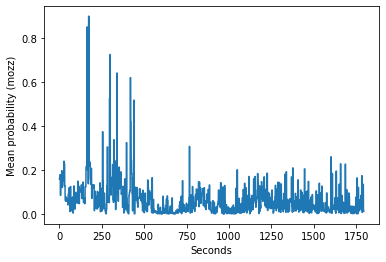

2020-11-10_05.28.03.953.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0500/2020-11-10_05.28.03.953.wav
[]


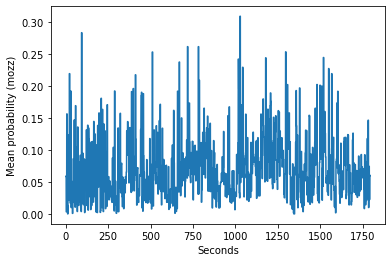

2020-11-10_05.58.03.969.wav
D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/0500/2020-11-10_05.58.03.969.wav
[]


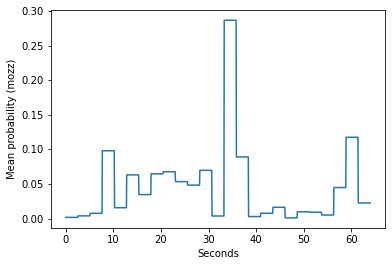

In [543]:
def get_wav_for_path(noise_path_names, sr):
    x = []
    signal_length = 0
    for path in noise_path_names:
        print(path)
        signal, _ = librosa.load(path, sr=sr)
        x.append(signal)
        signal_length += len(signal)/sr
    return x, signal_length


# Updated version of file detection from util.py here:

# raw = [r'D:\Postdoc\Data\Semi Field Data\UK bednet trial\PHONE A\2020-09-08_19.04.55.928__v0.wav']
# filtered = [r'D:\Postdoc\MozzDetectorTestingSQL\Code\notebooks\proc_data\VADout\2020-09-08_19.04.55.928__v0.wav']
# TzA = [r'D:\Postdoc\MozzDetectorTestingSQL\Code\notebooks\proc_data\VADout\TanzaniaBednetOctober\01-10-2020\B2\2020-10-01_18.44.21.802__v3.wav']
# TzAraw = [r'D:\Postdoc\Data\Semi Field Data\TanzaniaBednetOctober\01-10-2020\B2\2020-10-01_18.44.21.802__v3.wav']
# # Confirmed noise (Dav):
dav_noise = [r'D:\Postdoc\MozzDetectorTestingSQL\Data\Experiments\sounds\noise0.wav',
             r'D:\Postdoc\MozzDetectorTestingSQL\Data\Experiments\sounds\noise1.wav',
             r'D:\Postdoc\MozzDetectorTestingSQL\Data\Experiments\sounds\noise2.wav', 
             r'D:\Postdoc\MozzDetectorTestingSQL\Data\Experiments\sounds\noise3.wav',
             r'D:\Postdoc\MozzDetectorTestingSQL\Data\Experiments\sounds\noise4.wav',
             r'D:\Postdoc\MozzDetectorTestingSQL\Data\Experiments\sounds\noise5.wav', 
             r'D:\Postdoc\MozzDetectorTestingSQL\Data\Experiments\sounds\noise6.wav']




sr = 8000

# Tanzania
# directory = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/VADout/Semi Field Data/TanzaniaBednetOctober/02-10-2020/'
# subdirectories = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4']

directory = 'D:/Postdoc/Data/Semi Field Data/TanzaniaBednetOctober/2020-10-15 - 2020-10-16/'
# directory = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/VADout/Semi Field Data/TanzaniaBednetOctober/2020-10-15 - 2020-10-16/'
subdirectories = ['A1', 'B1']
dir_out = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/label_out/Semi Field Data/TanzaniaBednetOctober/2020-10-15 - 2020-10-16/'

# # # subdirectories = ['A1']
# directory = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/label_out/debug/alignment'
# dir_out = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/label_out/debug/alignment'

# subdirectories = ['']


# # UK bednet
# directory = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/VADout/Semi Field Data/UK bednet trial/'
# subdirectories = ['PHONE A','PHONE B']
# dir_out = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/Classifierout/VADout/Semi Field Data/UK bednet trial/'


# Thai
# directory = 'D:/Postdoc/MozzDetectorTestingSQL/Data/Thai/'
# subdirectories = ['sounds']
# dir_out = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/Classifierout/Thai/'

# directory  = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/label_out/debug/music/'
# subdirectories = ['']
# dir_out = directory
# directory = 'F:\Music\Guitar Playthroughs\Audacity'



directory = 'D:/Postdoc/Data/OneDrive_2020-11-30/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/2020-11-10/'
subdirectories = ['0000', '0100', '0200', '0300', '0400', '0500']
dir_out = 'D:/Postdoc/MozzDetectorTestingSQL/Code/notebooks/proc_data/label_out/debug/IFAKARA - NOVEMBER 2020 BEDNET PHONE DOWNLOADS/9to10-11-20/C1/'

#CNN:
to_filter = False
norm = False
step_size=40
BNN = True
n_samples = 10

if norm:
    mean= np.load('mean_norm.npy')
    std = np.load('std_norm.npy')
else:
    mean = 0
    std = 1

for subdir in subdirectories:
    listdirectory = os.listdir(directory + subdir) # gets the name of all files in your dir
    for filename in listdirectory: 
        if filename.endswith(".wav"): # check each of the files for whether or not they end in .wav:
            print(filename)
            x, x_l = get_wav_for_path([directory + subdir + '/' + filename], sr =8000)
#             print(np.shape(x))
#             X = util.get_feat(x, sr=8000, feat_type=feat_type, flatten = flatten, n_feat=n_feat)
            X_CNN = util.get_feat(x, sr=8000, feat_type=feat_type, n_feat=n_feat, flatten = False)
    
            X_CNN = util.reshape_feat(X_CNN, win_size=win_size, step_size=step_size)
#             X_CNN = (X_CNN - mean)/std
#             print(np.shape(X_CNN))
            
            if BNN:
                out = []
                for i in range(n_samples):
                    out.append(model.predict(X_CNN))
                
                G_X, U_X, _ = active_BALD(np.log(out), X_CNN, 2)
                preds_list = detect_timestamps_BNN(np.repeat(np.mean(out, axis=0), step_size, axis=0),
                                      np.repeat(G_X, step_size, axis=0),
                                      np.repeat(U_X, step_size, axis=0))   
            
            if to_filter:
                preds_filt = np.zeros([len(preds_CNN),2])
                preds_filt[:,1] = medfilt(preds_CNN[:,1], kernel_size=51)
                preds_filt[:,0] = 1 - preds_filt[:,1]
                preds_CNN = preds_filt
            
#             preds_list = util.detect_timestamps_BNN(np.repeat(preds_CNN, step_size, axis=0))
            print(preds_list)
            plt.plot((1/sr)*librosa.frames_to_samples(np.arange(len(np.repeat(np.mean(out, axis=0),step_size, axis=0))), hop_length=512),
                                               np.repeat(np.mean(out, axis=0), step_size, axis=0)[:,1])
            plt.xlabel('Seconds')
            plt.ylabel('Mean probability (mozz)')
            plt.show()
#             preds_prob = clf.predict_proba(X)
#             preds_list = util.detect_timestamps(preds_prob)
#             plt.plot(preds_prob[:,1])
#             plt.show()
#             print(np.shape(preds_CNN))
#             print(np.shape(preds_prob))
#             ipdb.set_trace()
                    
            if not os.path.exists(dir_out + subdir): os.makedirs(dir_out + subdir)
#             with open(dir_out + subdir + '/mozz_pred_list' + filename + '.pkl', 'wb') as f:
#                 pickle.dump(preds_list, f)
            np.savetxt(dir_out + subdir + '/' + 'BNN_step_40_' + str(model_name) + filename + '.txt', preds_list, fmt='%s', delimiter='\t')
                               

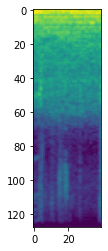

In [436]:
plt.imshow(X_CNN[1].reshape(40,128).T)

In [439]:
ipd.Audio(x,rate=8000)


In [398]:
preds_list

[['512.0', '514.56', '0.65 PE: 0.93 MI: 0.20'],
 ['663.04', '665.6', '0.63 PE: 0.95 MI: 0.29'],
 ['821.76', '824.32', '0.88 PE: 0.52 MI: 0.06'],
 ['988.16', '990.72', '0.51 PE: 1.00 MI: 0.23'],
 ['1331.2', '1333.76', '0.63 PE: 0.95 MI: 0.27'],
 ['1610.24', '1612.8', '0.54 PE: 1.00 MI: 0.26'],
 ['1651.2', '1653.76', '0.63 PE: 0.95 MI: 0.28'],
 ['1907.2', '1909.76', '0.69 PE: 0.89 MI: 0.17'],
 ['3335.68', '3340.8', '0.79 PE: 0.56 MI: 0.12'],
 ['3343.36', '3345.92', '0.66 PE: 0.92 MI: 0.28'],
 ['3415.04', '3417.6', '0.98 PE: 0.12 MI: 0.04']]

In [28]:
# # Dataset split 18/11: WHOLE database of signal and noise
# print(len(X_s_tr))
# print(len(X_n_tr))
# print(len(X_n_Thai))
# print(len(X_n_Culex))
# print(len(X_n_add_Culex))
# print(len(X_n_add_CDC))
# print(len(X_n_add_dav))

# X_n_db =  np.vstack([X_n_tr, X_n_Thai, X_n_Culex, X_n_add_Culex, X_n_add_CDC, X_n_add_dav])
# X_tr = np.vstack([X_s_tr, X_n_db])



In [29]:
# Used before 18/11/20 to train
X_tr = np.vstack([X_s_tr, shuffle(X_n_tr)[:len(X_s_tr)]])
# X_tr = X_tr[:,1:]
print(np.shape(X_tr))

ValueError: could not broadcast input array from shape (40,32) into shape (40)

In [ ]:
# X_s_te = X_s_te[:,1:]

In [ ]:
# X_tr = np.vstack([X_s_tr, shuffle(X_n_tr)[:len(X_s_tr)]])
# X_tr = X_tr[:,1:]
y_tr = np.zeros(len(X_tr))
y_tr[:len(X_s_tr)] = 1
plt.plot(y_tr)
y_te = np.hstack([np.ones(len(X_s_te)), np.zeros(len(X_n_Culex)), np.zeros(len(X_n_add_Culex))])
y_te = np.ones(len(X_s_te))

# Train model

In [34]:
np.shape(y_train)

(285555, 2)

In [35]:
clf = RandomForestClassifier(max_depth=5, random_state=0, verbose=0, n_jobs=-1)
# clf = SVC(verbose=2, probability=False)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [1]:
accuracy_score(clf.predict(X_tr), y_tr)

NameError: name 'accuracy_score' is not defined

In [ ]:
accuracy_score(clf.predict(X_tr), y_tr)

In [ ]:
# from sklearn.neural_network import MLPClassifier

# clf = MLPClassifier(random_state=1, hidden_layer_sizes=(128,128,64))
# clf.fit(X_tr, y_tr)

# Save classifier

In [36]:
import pickle

with open('clf_mfcc-cut-depth5-BNN_split.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

Signal acc 0.9082336336810901


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

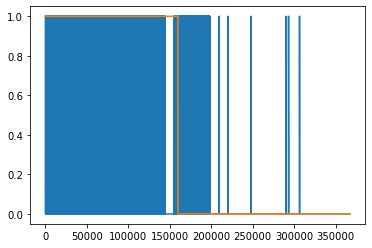

In [43]:
preds = clf.predict(X_test)
print('Signal acc', accuracy_score(y_test, preds))

plt.figure()
plt.plot(preds[:,1])
plt.plot(y_test[:,1])

preds = clf.predict(np.vstack([X_n_Culex, X_n_add_Culex]))
y_te = np.hstack([np.zeros(len(X_n_Culex)), np.zeros(len(X_n_add_Culex))])

print('Noise acc', accuracy_score(y_te, preds))
plt.figure()
plt.plot(preds, '.')
plt.plot(y_te)


# Evaluate Model

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [ ]:
_,_ = util.df_metadata(df_train, plot=True, filepath='Graphs/Train2.pdf')
_,_ = util.df_metadata(df_test, plot=True, filepath='Graphs/Test2.pdf')


In [ ]:
print('Test set processing (i) ...')
species_wav_dict = {}
for species in df_test["species"].unique():
    x, signal_length = util.get_wav_for_df(df_test[df_test["species"] == species], 8000)
    species_wav_dict[species.strip().strip("\'")] = [x, signal_length] # Correct for odd spacing and syntax in database (Maybe check SQL query?
    print('Completed wav extraction for species', species)

In [ ]:
print('Test set processing (ii) ...')
accs = []
for species in species_wav_dict.keys():
    X_test = util.get_feat(species_wav_dict[species][0], sr=8000, feat_type='log-mel')
    y_test = np.ones(np.shape(X_test)[0])
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds) 
    accs.append(acc)
    print('Seconds for species:', species,  species_wav_dict[species][1], 'acc', acc)
plt.bar([*list(species_wav_dict.keys())[:-1], 'larvae'], accs)
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Accuracy per species')
# plt.savefig('Graphs/RFtestsignal2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
preds = clf.predict(X_n_Culex)
acc = accuracy_score(np.zeros(len(X_n_Culex)),preds) 
print('Seconds for Culex noise:', s_n_Culex, 'acc', acc)
plt.bar('Culex implied noise', acc)
preds = clf.predict(X_n_add_Culex)
acc = accuracy_score(np.zeros(len(X_n_add_Culex)),preds) 
print('Seconds for Culex additional noise files:', s_n_add_Culex, 'acc', acc)
plt.bar('Culex files noise', acc)
preds = clf.predict(X_n_Thai)
acc = accuracy_score(np.zeros(len(X_n_Thai)),preds) 
print('Seconds for Thai assumed 0 noise files:', s_n_Thai, 'acc', acc)
plt.bar('Thai implied noise', acc)

preds = clf.predict(X_n_add_dav)
acc = accuracy_score(np.zeros(len(X_n_add_dav)),preds) 
print('Seconds for Davide varied 0, noise files:', s_n_add_dav, 'acc', acc)
plt.bar('Davide speech', acc)


preds = clf.predict(X_n_add_CDC)
acc = accuracy_score(np.zeros(len(X_n_add_CDC)),preds) 
print('Seconds for CDC files 0, noise files:', s_n_add_dav, 'acc', acc)
plt.bar('CDC files noise', acc)

plt.xticks(rotation=90)
plt.grid(axis = 'y', which='both')
plt.ylabel('Accuracy per class')
plt.minorticks_on()
# plt.savefig('Graphs/SVMtestnoise.pdf', bbox_inches='tight')
plt.show()



## Create overall confusion matrix

In [ ]:
# Stack full data together

y_te = np.hstack([np.ones(len(X_s_te)), np.zeros(len(X_n_Culex)), np.zeros(len(X_n_add_Culex)),
                  np.zeros(len(X_n_Thai)), np.zeros(len(X_n_add_dav))])
X_te = np.vstack([X_s_te, X_n_Culex, X_n_add_Culex,
                  X_n_Thai, X_n_add_dav])

# preds = clf.predict(X_te)
# accuracy_score(y_te, preds)
# plot_confusion_matrix(clf, X_test, y_test)  # doctest: +SKIP
# plt.show()  # doctest: +SKIP

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_te, y_te, normalize='true', cmap=plt.cm.Blues)  # doctest: +SKIP
# plt.savefig('Graphs/SVMconfnormunbalanced.pdf', bbox_inches='tight')
plt.show()  # doctest: +SKIP

plot_confusion_matrix(clf, X_te, y_te, normalize=None, cmap=plt.cm.Blues, values_format='d')  # doctest: +SKIP
# plt.savefig('Graphs/SVMconfunbalanced.pdf', bbox_inches='tight')
plt.show()  # doctest: +SKIP

In [ ]:
# Stack balanced test data together

y_te = np.hstack([np.ones(len(X_s_te[:18063])), np.zeros(len(X_s_te[:18063]))])
X_te = np.vstack([shuffle(X_s_te)[:18063], shuffle(X_n_add_Culex)[:6021],
                  shuffle(X_n_Thai)[:6021], shuffle(X_n_add_dav)[:]])
plot_confusion_matrix(clf, X_te, y_te, normalize='true',cmap=plt.cm.Blues)  # doctest: +SKIP
# plt.savefig('Graphs/RFconfnormbalanced.pdf', bbox_inches='tight')
plt.show()  # doctest: +SKIP
plot_confusion_matrix(clf, X_te, y_te, normalize=None,cmap=plt.cm.Blues, values_format='d')  # doctest: +SKIP
# plt.savefig('Graphs/RFconfbalanced.pdf', bbox_inches='tight')
plt.show()  # doctest: +SKIP


In [2]:
preds = clf.predict(X_te)
accuracy_score(y_te, preds)

NameError: name 'clf' is not defined

# Bug reports

* ```19 June 2018_359_379cow```: End time of signal is longer than actual signal?

* Events are marked with mosquito "deaths" as point labels, where end time = start time:

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 933```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 935```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 936```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 938```

* Larvae are not marked as mosquito, species information absent from labels

* Noise labels are not consistent in experiments: some data is marked as "background", some is untagged, some recordings contain positive labels with the implication that the negative labels are noise, whereas other recordings only strongly label positive events, ignoring lower SNR positives
* Errors in record datetime 30/07 vs 30/06.. not all entries have a datetime label
* Some extracted Thai noise contains mosquito: maybe write padding to cut down the assumed noise with a small margin for error to be safe

645-657: label missing species for:

`98.014746	105.544811	#651cow
109.454388	131.549004	#652cow
136.725064	156.988787	#653cow
161.201218	177.720557	#654cow
182.111948	194.818073	#655cow
197.571296	206.064990	#656cow
209.602882	223.313930	#657cow`

species present in:

`26.413735	37.526432	#645COW
42.499442	55.591018	#646COW
60.715454	68.906293	#647COW`




#235-239.txt and 17 June 2018_235-239cow.txt: recordings appear really similar other than sample rate:
# two label tracks are supplied (???)
235-239 MISSING LAST LABEL: 20 SEC MOSQUITO LABELLED AS NOISE
    
WE CANNOT ASSUME NON 1S ARE NOISE: in Thai data, we filtered all the data by *species info having to be in original database entry*, hence this discarded a significant amount of training data and led to the non 1 assumption not being true in Thai, but working fine in Culex.
    

# Fixes

Load dataframe with mosquito +ve but no species present in same query. Can filter further in pandas in Python to test by species